#TODO
- Understand why training overfits initial RFFs
- Check numerical gradients and analytical gradients are equal
- Host and download the domain being trained on.
- Prepare datasets of dim > 2 (i.e. not images)
- Generalize code to dim > 2

#Dependencies and Imports

In [1]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os, imageio
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import TensorDataset
from torch import nn, optim
from itertools import chain
import matplotlib.pyplot as plt
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f"Using {device} device")

Using cuda device


#Global Parameters

In [25]:
sigma = 1. # Feature sampling sd
feature_num = 3 # Starting number of features
sample_size = 1000 # How many random feature samples when finding new feature
learning_rate = 1e-3
model_size = 64
loss_fn = nn.MSELoss()

#Dataset Preparation

In [4]:
# Make dataset, taken from https://github.com/jmclong/random-fourier-features-pytorch
image = torchvision.io.read_image('circle.jpg').float()
_, H, W = image.shape
def linspace_func(nx): return torch.linspace(0.0, 1.0, nx)
linspaces = map(linspace_func, (H, W))
coordinates = torch.meshgrid(*linspaces, indexing='ij')
rect_coords = torch.stack(coordinates, dim=-1)
image = image.permute((1, 2, 0))
image /= 255.0
coords = rect_coords.flatten(0, -2)
image = image.flatten(0, -2)
dataset = TensorDataset(coords, image)

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices = indices

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)

train_dataloader = DataLoader(dataset, batch_size=1024, sampler=train_sampler)
expand_dataloader = DataLoader(dataset, batch_size=1024, sampler=train_sampler)

#MLP Data Structures

In [5]:
# Fourier transform receive layer
class TransitionLayer(nn.Module):
    def __init__(self, feature_num, size):
        super(TransitionLayer, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(nn.Linear(feature_num,size))

    def forward(self, x):
        return self.layers(x)
    
# Fourier Space MLP fit
class NeuralNetwork(nn.Module):
    def  __init__(self, size):
        super(NeuralNetwork, self).__init__()
        self.size = size
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            #nn.Linear(10, 16),
            #SineLayer(),
            nn.Tanh(),
            nn.Linear(size, size),
            #SineLayer(),
            nn.Tanh(),
            nn.Linear(size, 3)
        )

    def forward(self, x):
        return self.layers(x)

# Gaussian Encoding Layer
class GaussianEncoding(nn.Module):
  def __init__(self, sigma, input_size, feature_num):
    super(GaussianEncoding, self).__init__()
    self.b = torch.randn((feature_num, input_size)) * sigma
    self.b = self.b.to(device)

  def forward(self, x):
    return torch.sin(2 * np.pi * x @ self.b.T)

# Sine Layer
class SineLayer(nn.Module):  
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        return torch.sin(input)

#Feature Expansion

In [6]:
def findFeature(encoding, transition_layer, model):
  z = transition_layer(encoding(X))
  preds = model(z)
  gz = sum(preds)
  #print(z.shape)
  #print(gz.shape)
  dgdz = torch.zeros([3,z.shape[0],z.shape[1]])
  for i in range(3):
    dgdz_coord = torch.autograd.grad(gz[i], z, retain_graph=True)
    dgdz[i,:,:] = dgdz_coord[0]
  #print('dgdz')
  #print(dgdz.shape)
  dgdz = dgdz.to(device)
  best_dldw = 0
  for i in range(sample_size):
    a = torch.randn((1,2)).to(device)
    ax = torch.matmul(a, torch.permute(X, (1,0)))
    pred_minus_y = torch.add(preds,y,alpha=-1)
    pred_minus_y = torch.reshape(pred_minus_y,(pred_minus_y.shape[0],pred_minus_y.shape[1],1))
    pred_minus_y = torch.permute(pred_minus_y, (1,0,2))
    #print('p - y')
    #print(pred_minus_y.shape)
    two_terms = torch.mul(pred_minus_y, dgdz)
    #print('ax')
    #print(ax.shape)
    #print (two_terms.shape)
    dLdw = torch.mul(torch.permute(two_terms,(0,2,1)), torch.sin(ax))
    #print('dLdw')
    #print(dLdw.shape)
    dLdw = torch.sum(dLdw, dim=(0,2))
    #print('dLdw summed over dimensions')
    #print(dLdw)
    norm = torch.linalg.vector_norm(dLdw)
    #print('norm')
    #print(norm)
    if norm > best_dldw:
      best_dldw = norm
      best_a = a
  best_feature = makeFeatureEncoding(encoding, best_a, feature_num)
  '''best_feature = GaussianEncoding(sigma, 2, feature_num).to(device)
  encoding_sd = encoding.state_dict()
  best_feature.load_state_dict(encoding_sd, strict=False)
  best_feature.b = torch.nn.Parameter(F.pad(input=encoding.b, pad=(0,0,0,1), mode='constant', value=0))
  best_feature.b.data[-1] = best_a'''
  print("New feature with dldw " + str(best_dldw.item()))
  return best_feature, best_dldw

def randFeature(encoding):
  rand_feature = GaussianEncoding(sigma, 2, feature_num).to(device)
  encoding_sd = encoding.state_dict()
  rand_feature.load_state_dict(encoding_sd, strict=False)
  rand_feature.b = torch.nn.Parameter(F.pad(input=encoding.b, pad=(0,0,0,1), mode='constant', value=0))
  rand_feature.b.data[-1] = torch.randn((1,2)).to(device)
  
def makeFeatureEncoding(encoding, feature, feature_num):
  encoding_sd = encoding.state_dict()
  new_feature = GaussianEncoding(sigma, 2, feature_num).to(device)
  new_feature.load_state_dict(encoding_sd, strict=False)
  new_feature.b = torch.nn.Parameter(F.pad(input=encoding.b, pad=(0,0,0,1), mode='constant', value=0))
  new_feature.b.data[-1] = feature
  return new_feature

In [13]:
def expandTransition(transition_layer):
  transition_sd = transition_layer.state_dict()
  expanded_transition = TransitionLayer(feature_num, model_size).to(device)
  expanded_transition.load_state_dict(transition_sd, strict=False)
  trans_weights = transition_layer.layers[0].weight
  pad_weights = torch.nn.Parameter(F.pad(input=trans_weights, pad=(0,1,0,0), mode='constant', value=0))
  #pad_weights.data[:,-1] = torch.randn(pad_weights[:,-1].shape)
  expanded_transition.layers[0].weight = pad_weights
  return expanded_transition

def expandModel(model):
  #return model
  model_sd = model.state_dict()
  expanded_model = NeuralNetwork(model_size).to(device)
  expanded_model.load_state_dict(model_sd, strict = False)
  for layer in expanded_model.layers:
    if isinstance(layer, nn.Linear) and layer != expanded_model.layers[-1]:
      new_weights = torch.nn.Parameter(F.pad(input=layer.weight, pad=(0,1,0,1), mode='constant', value=0))
      layer.weight = new_weights
  return expanded_model

In [28]:
def expandFeatures(feature_num, model_size, model, transition_layer, encoding):
  expanded_transition = expandTransition(transition_layer)
  #expanded_model = expandModel(model)
  best_feature, best_dldw = findFeature(encoding, transition_layer, model)
  # best_feature = randFeature(encoding)
  numerical_grad = checkGrad(best_feature.b.data[-1], encoding, expanded_transition, model, 1, feature_num)
  print("Numerical gradient: " + str(numerical_grad.item()))
  feature_num += 1
  #model_size += 1
  return best_feature, expanded_transition, model, best_dldw

def checkGrad(feature, encoding, transition_layer, model, epsilon, feature_num):
  plus_eps_ft = makeFeatureEncoding(encoding, torch.add(feature, epsilon), feature_num)
  minus_eps_ft = makeFeatureEncoding(encoding, torch.add(feature, -1*epsilon), feature_num)
  plus_eps = model(transition_layer(plus_eps_ft(X)))
  minus_eps = model(transition_layer(minus_eps_ft(X)))
  numerical_grad = torch.mul(torch.sub(plus_eps,minus_eps), 1./(2*epsilon))
  breakpoint()
  return torch.linalg.vector_norm(torch.sum(numerical_grad, dim = 0))

#Training

In [9]:
def checkStall(losses):
    n = 100
    iter = len(losses) - 1
    if iter < n: return False
    time = np.array([i for i in range(n)])
    loss_array = np.array(losses[-(n+1):-1])
    p = np.polyfit(time, loss_array, 1)
    return p[0] > -1e-5 # Tweak this

In [10]:
b, (X, y) = next(enumerate(train_dataloader))

In [29]:
#Training code
transition_layer = TransitionLayer(feature_num, model_size)
transition_layer = transition_layer.to(device)
model = NeuralNetwork(model_size)
model = model.to(device)

loss_fn = nn.MSELoss()
params = chain(transition_layer.parameters(), model.parameters())
optimizer = optim.SGD(params, lr=learning_rate) 
encoding = GaussianEncoding(1., 2, feature_num).to(device)
epochs = 5

losses = []
slopes = []
dldws = {}
stalls = [0]
batch_losses = []
#b, (X, y) = next(enumerate(train_dataloader))

for i in range(10000):
  #for batch_index, (X, y) in enumerate(train_dataloader):
  X = X.to(device)
  y = y.to(device)
  Xp = encoding(X)
  pred = model(transition_layer(Xp))
  loss = loss_fn(pred, y)
  losses.append(loss.item())
  if (i > 2):
    slopes.append((losses[-1] - losses[-2])/learning_rate)
  if (len(losses) + 1) % 1000 == 0:
    print("loss: " + str(np.mean(losses[-1:-101:-1])) + "\nslope: " + str(slopes[-1]))
  #if False:
  if(((len(losses) - stalls[-1]) > 100  and checkStall(losses)) and feature_num < 10):
    stalls.append(len(losses))
    encoding, transition_layer, model, dldw = expandFeatures(feature_num, model_size, model, transition_layer, encoding)
    params = chain(transition_layer.parameters(), model.parameters())
    optimizer = optim.SGD(params, lr=learning_rate)
    feature_num += 1
    dldws[len(losses)] = dldw
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()
with torch.no_grad():
    feature_coords = encoding(rect_coords.to(device))
    image = model(transition_layer(feature_coords))
    plt.imshow(image.cpu().numpy())
    plt.show()

loss: 0.054886562563478944
slope: -0.010855495929718018
New feature with dldw 21.634742736816406
> <ipython-input-28-a43067169ae3>(19)checkGrad()
-> return torch.linalg.vector_norm(torch.sum(numerical_grad, dim = 0))
(Pdb) numerical_grad
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], device='cuda:0', grad_fn=<MulBackward0>)
--KeyboardInterrupt--
(Pdb) q


BdbQuit: ignored

# Local Variables

In [ ]:
gradients_num = [0] + [(losses[i+1] - losses[i-1])/(2*learning_rate) for i in range(1,len(losses)-1)] + [0]
for stall in stalls:
  if stall == 0: continue
  print("At iter " + str(stall))
  print("Numerical Gradient: " + str(gradients_num[stall]))
  print("Analytical Gradient: " + str(dldws[stall].item()) + "\n")

At iter 1035
Numerical Gradient: -0.008530914783477783
Analytical Gradient: 36.35417938232422

At iter 1136
Numerical Gradient: -0.006843358278274536
Analytical Gradient: 39.96036911010742

At iter 1237
Numerical Gradient: -0.005587935447692871
Analytical Gradient: 30.55134391784668

At iter 1338
Numerical Gradient: -0.004604458808898926
Analytical Gradient: 34.71858215332031

At iter 1439
Numerical Gradient: -0.0038258731365203857
Analytical Gradient: 40.54592514038086

At iter 1540
Numerical Gradient: -0.003207474946975708
Analytical Gradient: 34.62732696533203

At iter 1641
Numerical Gradient: -0.002730637788772583
Analytical Gradient: 33.418800354003906



In [ ]:
# Check weights
weights = transition_layer.layers[0].weight
torch.linalg.norm(weights, dim=0)

tensor([2.5441, 2.7865, 2.4804, 0.0197, 0.0390, 0.0114, 0.0176, 0.0295, 0.0269,
        0.0327], device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [ ]:
model.layers[1]

Linear(in_features=64, out_features=64, bias=True)

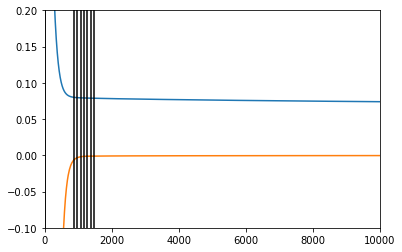

[0, 873, 974, 1075, 1176, 1277, 1378, 1479]


In [ ]:
# Visualize loss over iteration and stalls
plt.plot(losses)
plt.plot(slopes)
for stall in stalls:
  plt.axvline(x=stall, color = 'k')
plt.axis([0,10000,-0.1,0.2])
plt.show()
print(stalls)